## GENERAL SETUP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.planets import PlanetModel

## PLOT SETUP

In [4]:
print(
    "TODO: PLOT LABELS, COLOR MAPS, SAVING FUNCTION (NAMES AND GALLIFREY PATH, MAYBE SEPERATE SAVE FUNCTION AS PART OF GALLIFREY THAT TAKES FIG OBJECT), PAIR PLOT DIAGONALS AND CORNERS, INT VALUES IN COLORBAR LABEL"
)
print("CLEAN UP CODE")
print("WHAT TO DO AS CORNER PLOTS AND AS DIAGONAL PLOTS")
print(
    "RIDGE PLOT 1: ALL CATEGORIES AT ONE FIXED [FE/H] AND OTHER VARIABLES SAMPLED -> INTRINSIC VARIATIONS UNRELATED TO METALLICITY"
)
print(
    "RIDGE PLOT 2: ONE CATEGORY, ALL VARIABLES SAMPLES, DIFFERENT STAR MASSES -> VARIATIONS WITH STAR MASS (VERY DIFFERENT FOR DIFFERENT CATEGORIES, NEED ANOTHER PLOT TO SHOW THAT"
)
print("maybe add lower metallicity cut, see if that changes things")

TODO: PLOT LABELS, COLOR MAPS, SAVING FUNCTION (NAMES AND GALLIFREY PATH, MAYBE SEPERATE SAVE FUNCTION AS PART OF GALLIFREY THAT TAKES FIG OBJECT), PAIR PLOT DIAGONALS AND CORNERS, INT VALUES IN COLORBAR LABEL
CLEAN UP CODE
WHAT TO DO AS CORNER PLOTS AND AS DIAGONAL PLOTS
RIDGE PLOT 1: ALL CATEGORIES AT ONE FIXED [FE/H] AND OTHER VARIABLES SAMPLED -> INTRINSIC VARIATIONS UNRELATED TO METALLICITY
RIDGE PLOT 2: ONE CATEGORY, ALL VARIABLES SAMPLES, DIFFERENT STAR MASSES -> VARIATIONS WITH STAR MASS (VERY DIFFERENT FOR DIFFERENT CATEGORIES, NEED ANOTHER PLOT TO SHOW THAT


In [5]:
sns.set(rc={"figure.figsize": (18.5, 10.5)}, font_scale=2)
sns.set_style("whitegrid", {"axes.grid": False})
sns.set_palette("pastel")
print("Try to make this a function or better yet, a file")

Try to make this a function or better yet, a file


## INTERPOLATION BEHAVIOUR

In [6]:
num_embryos = 50
category = "Giant"
host_star_mass = 1
age = int(1e8)
num_samples = int(1e6)

planet_model = PlanetModel(num_embryos)

population_id = planet_model.get_population_id(num_embryos, host_star_mass)

### Uniform Sampling Of Monte Carlo Variables

In [7]:
bounds = planet_model.get_systems(population_id).bounds
samples = np.column_stack(
    [np.random.uniform(bound[0], bound[1], num_samples) for bound in bounds.values()]
)
samples = pd.DataFrame(samples, columns=bounds.keys())
samples["age"] = age

In [8]:
result = planet_model.prediction(
    category, host_star_mass, variables=samples, return_full=True
)
result["Planet Bins"] = pd.cut(result[category].replace(0, 1e-5), bins=[0, 1, 2, 3])
print(
    "adding tiny amount to value=0 category, in order for plot to have a lower limit at 0"
)

adding tiny amount to value=0 category, in order for plot to have a lower limit at 0


In [9]:
print(
    "Make this a function that only maps the values actually found in dataframe and returns corresponding labels"
)
label_mapping = {
    "log_initial_mass": r"log $M_\mathrm{g}$",
    "[Fe/H]": "[Fe/H]",
    "log_photoevaporation": r"log $\dot{M}_\mathrm{wind}$",
    "log_inner_edge": r"log $r_\mathrm{in}$",
}
labels = list(label_mapping.values())
result = result.rename(columns=label_mapping)

Make this a function that only maps the values actually found in dataframe and returns corresponding labels


Can add {'stat':'density', 'common_norm':False} to normalise diag plots


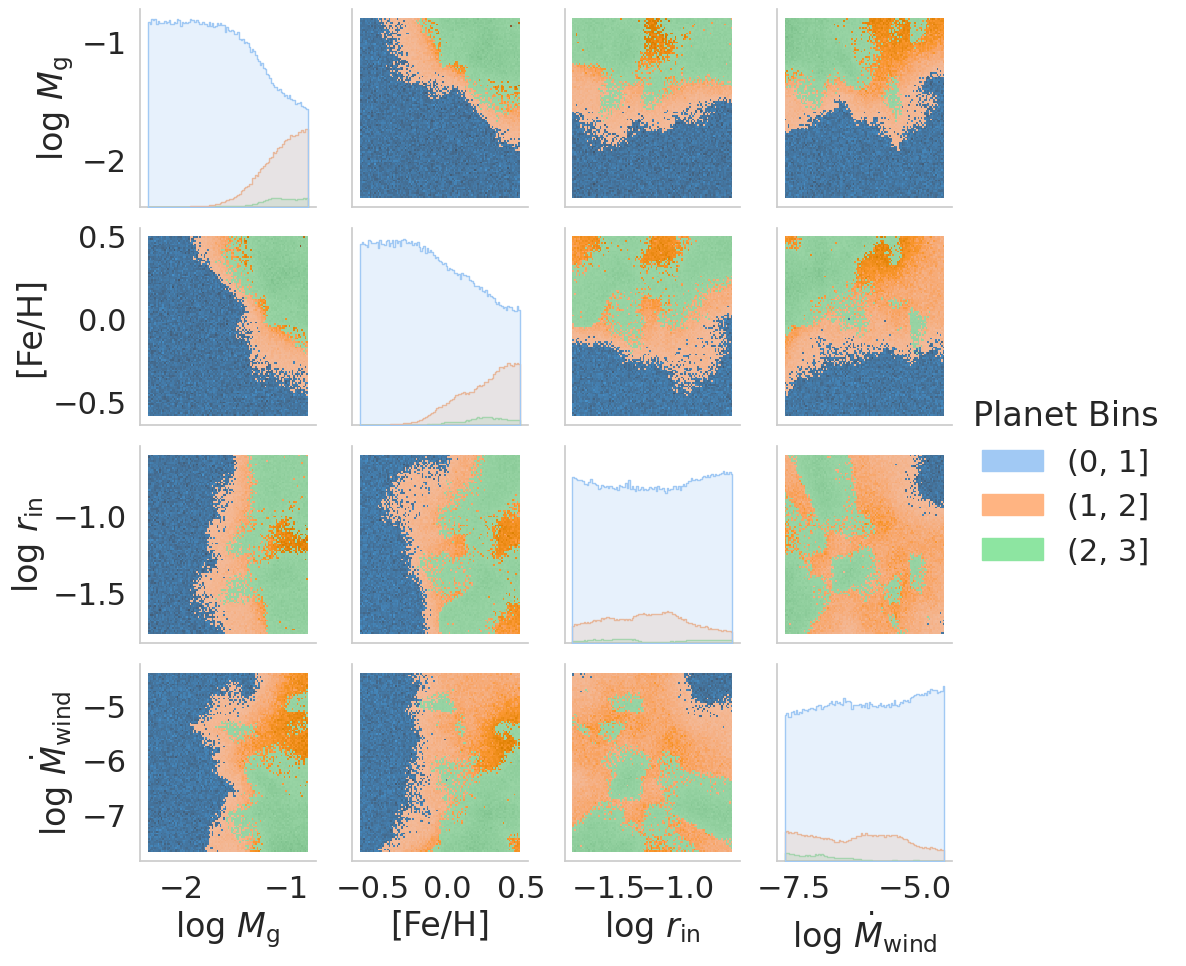

In [10]:
print("Can add {'stat':'density', 'common_norm':False} to normalise diag plots")
plot = sns.pairplot(
    result.drop(columns=["age", category]),
    hue="Planet Bins",
    kind="hist",
    diag_kws={"element": "step"},
)
plot.figure.savefig("plots/planet_model_interpolation.pdf")